# **Agents Estimation and AQI prediction**

After finding the best model for each agent, use them to compute the complessive pollution estimatins and compute AQI values.

## Notebook Setup

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from utils import *

datasets_folder = './datasets'
verbosity = 0
figsize = (18,4)

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

[]


In [2]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [3]:
station_data = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
        # bin_size = 8,
        # offset = 2
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 33


In [4]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'

In [5]:
train_sets = {}
test_sets = {}

for station in stations:
    train_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        train_sets[station][agent] = {}
        test_sets[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent], train_split_date, y=target)

        train_sets[station][agent]['x'] = x_train
        train_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = x_test
        test_sets[station][agent]['y'] = y_test

## Agents Estimations

Prepare a dictionary containing the model to use for each agent of each station

### **Hourly models**

#### LSTM

In [6]:
lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'lstm_units': 128,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error',
    'use_mask': True
}

lstm_train_params = {
    'epochs': 20,
    'batch_size': 64
}

lstm = ('LSTM-masked', build_lstm_model, lstm_params, lstm_train_params, True)

In [7]:
lstm2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'lstm_units': [64, 32],
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error',
    'use_mask': True
}

lstm2_train_params = {
    'epochs': 20,
    'batch_size': 32
}

lstm2 = ('LSTM_2-masked', build_lstm_model, lstm2_params, lstm2_train_params, True)

#### FFNN

In [8]:
ffnn_params = {
    'input_size': n_hour_features,
    'neurons': [1024, 512, 256, 128],
    'dropout': 0.2,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn_train_params = {
    'epochs': 10,
    'batch_size': 32
}

FFNN = ('Feed Forward NN', build_ffnn_model, ffnn_params, ffnn_train_params, False)

#### 1D Convolution

In [9]:
conv_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'filters': 64,
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}

conv_train_params = {
    'epochs': 10,
    'batch_size': 64
}

conv1d = ('Conv1D', build_conv_model, conv_params, conv_train_params, True)

### **Daily Models**

#### FFNN

In [10]:
ffnn_daily_params = {
    'input_size': n_daily_features,
    'neurons': [1024, 512, 256, 128],
    'optimizer': Adam(learning_rate=3e-4),
    'loss': 'mean_absolute_error'
}

ffnn_daily_train_params = {
    'epochs':20,
    'batch_size':32
}

FFNN_daily = ('Feed Forward NN', build_ffnn_model, ffnn_daily_params, ffnn_daily_train_params, False)

In [11]:
rfr_params = {
    'n_estimators':100,
    'max_depth':10,
    'min_samples_leaf': 5,
    'max_features': 'log2'
}

rfr = ('Random Forest Regressor', RandomForestRegressor, rfr_params, None, False)

In [12]:
# unused
xgbr_params = {
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 100,
    'subsample': 0.8,
    'random_state': 42
}

xgb = ('XGB Regressor', xgboost.XGBRegressor, xgbr_params, None, False)

### training

In [13]:
models = {
    'GIARDINI MARGHERITA':{
        'NO2': lstm, 
        'O3': lstm2,
        'PM10':FFNN_daily, # rfr,
        'PM2.5':FFNN_daily 
    },
    'PORTA SAN FELICE':{
        'C6H6': lstm, 
        'CO': FFNN, 
        'NO2': conv1d,
        'PM10':FFNN_daily,  
        'PM2.5':FFNN_daily 
    },
    'VIA CHIARINI':{
        'NO2': FFNN, 
        'O3': lstm2, 
        'PM10':FFNN_daily  
    }
}

In [14]:
agents_predictions = train_agents(models, train_sets, test_sets, model_out_folder='./models')

Predicting NO2 in GIARDINI MARGHERITA using LSTM-masked...


INFO:tensorflow:Assets written to: ./models\GIARDINI_MARGHERITA.NO2\assets


INFO:tensorflow:Assets written to: ./models\GIARDINI_MARGHERITA.NO2\assets


Predicting O3 in GIARDINI MARGHERITA using LSTM_2-masked...


INFO:tensorflow:Assets written to: ./models\GIARDINI_MARGHERITA.O3\assets


INFO:tensorflow:Assets written to: ./models\GIARDINI_MARGHERITA.O3\assets


Predicting PM10 in GIARDINI MARGHERITA using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models\GIARDINI_MARGHERITA.PM10\assets


INFO:tensorflow:Assets written to: ./models\GIARDINI_MARGHERITA.PM10\assets


Predicting PM2.5 in GIARDINI MARGHERITA using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models\GIARDINI_MARGHERITA.PM2_5\assets


INFO:tensorflow:Assets written to: ./models\GIARDINI_MARGHERITA.PM2_5\assets


Predicting C6H6 in PORTA SAN FELICE using LSTM-masked...


INFO:tensorflow:Assets written to: ./models\PORTA_SAN_FELICE.C6H6\assets


INFO:tensorflow:Assets written to: ./models\PORTA_SAN_FELICE.C6H6\assets


Predicting CO in PORTA SAN FELICE using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models\PORTA_SAN_FELICE.CO\assets


INFO:tensorflow:Assets written to: ./models\PORTA_SAN_FELICE.CO\assets


Predicting NO2 in PORTA SAN FELICE using Conv1D...


INFO:tensorflow:Assets written to: ./models\PORTA_SAN_FELICE.NO2\assets


INFO:tensorflow:Assets written to: ./models\PORTA_SAN_FELICE.NO2\assets


Predicting PM10 in PORTA SAN FELICE using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models\PORTA_SAN_FELICE.PM10\assets


INFO:tensorflow:Assets written to: ./models\PORTA_SAN_FELICE.PM10\assets


Predicting PM2.5 in PORTA SAN FELICE using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models\PORTA_SAN_FELICE.PM2_5\assets


INFO:tensorflow:Assets written to: ./models\PORTA_SAN_FELICE.PM2_5\assets


Predicting NO2 in VIA CHIARINI using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models\VIA_CHIARINI.NO2\assets


INFO:tensorflow:Assets written to: ./models\VIA_CHIARINI.NO2\assets


Predicting O3 in VIA CHIARINI using LSTM_2-masked...


INFO:tensorflow:Assets written to: ./models\VIA_CHIARINI.O3\assets


INFO:tensorflow:Assets written to: ./models\VIA_CHIARINI.O3\assets


Predicting PM10 in VIA CHIARINI using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models\VIA_CHIARINI.PM10\assets


INFO:tensorflow:Assets written to: ./models\VIA_CHIARINI.PM10\assets


In [15]:
metrics_predictions = training_results_to_dataframe(agents_predictions, multiple_models=False)
metrics_predictions

,Station,Agent,root_mean_squared_error,r2_score,mean_absolute_error,huber
0,GIARDINI MARGHERITA,NO2,7.059936,0.553219,4.909866,0.962241
1,GIARDINI MARGHERITA,O3,13.241178,0.862437,9.927077,1.965563
2,GIARDINI MARGHERITA,PM10,10.750466,0.378513,7.722738,1.524580
3,GIARDINI MARGHERITA,PM2.5,8.392430,0.480167,5.700471,1.120307
4,PORTA SAN FELICE,C6H6,0.414532,0.652896,0.261377,0.036539
5,PORTA SAN FELICE,CO,0.225210,0.495503,0.180120,0.019998
6,PORTA SAN FELICE,NO2,18.314299,-0.670149,15.264316,3.032921
7,PORTA SAN FELICE,PM10,10.898720,0.498435,7.233674,1.427020
8,PORTA SAN FELICE,PM2.5,7.360771,0.624751,5.170769,1.014238
9,VIA CHIARINI,NO2,6.648551,0.597455,5.168845,1.014092


## AQI calculation

In [ ]:
pred_AQIs_daily = {
    s: {agent: get_AQI(agents_predictions[s][agent]['predictions'], 
                        agent=agent, 
                        period='day', 
                        value_column='Agent_value',
                        ) for agent in agents_predictions[s].keys()} for s in agents_predictions
}

pred_AQI_daily = merge_AQIs(pred_AQIs_daily, period='day')

pred_AQIs_hourly = {
    s: {agent: get_AQI(agents_predictions[s][agent]['predictions'],
                       agent=agent,
                       period='hour', 
                       value_column='Agent_value',
                       include_hourly_pm=False
                       ) for agent in agents_predictions[s].keys()} for s in agents_predictions
}

pred_AQI_hourly = merge_AQIs(pred_AQIs_hourly, period='hour')

In [16]:
true_AQIs_daily = {
    s: {agent: get_AQI(test_sets[s][agent]['y'], 
                        agent=agent, 
                        period='day', 
                        value_column='Agent_value',
                        ) for agent in test_sets[s].keys()} for s in test_sets
}

true_AQI_daily = merge_AQIs(true_AQIs_daily, period='day')

true_AQIs_hourly = {
    s: {agent: get_AQI(test_sets[s][agent]['y'],
                       agent=agent,
                       period='hour', 
                       value_column='Agent_value',
                       include_hourly_pm=False
                       ) for agent in test_sets[s].keys()} for s in test_sets
}

true_AQI_hourly = merge_AQIs(true_AQIs_hourly, period='hour')

In [17]:
AQI_diff_daily = {}
AQI_diff_hourly = {}    

for station in true_AQI_hourly:
    AQI_diff_daily[station] = AQI_difference(pred_AQI_daily[station], true_AQI_daily[station])
    AQI_diff_hourly[station] = AQI_difference(pred_AQI_hourly[station], true_AQI_hourly[station])

## AQI Comparison

In [18]:
categories = {
    'Good': 0,
    'Moderate': 50,
    'Poor': 100,
    'Very Poor': 150,
    'Severe': 200,
}
# categories = {
#     'Good': 0,
#     'Moderate': 33,
#     'Poor': 66,
#     'Very Poor': 99,
#     'Severe': 132,
# }

### Hourly AQI

Station GIARDINI MARGHERITA AQI:


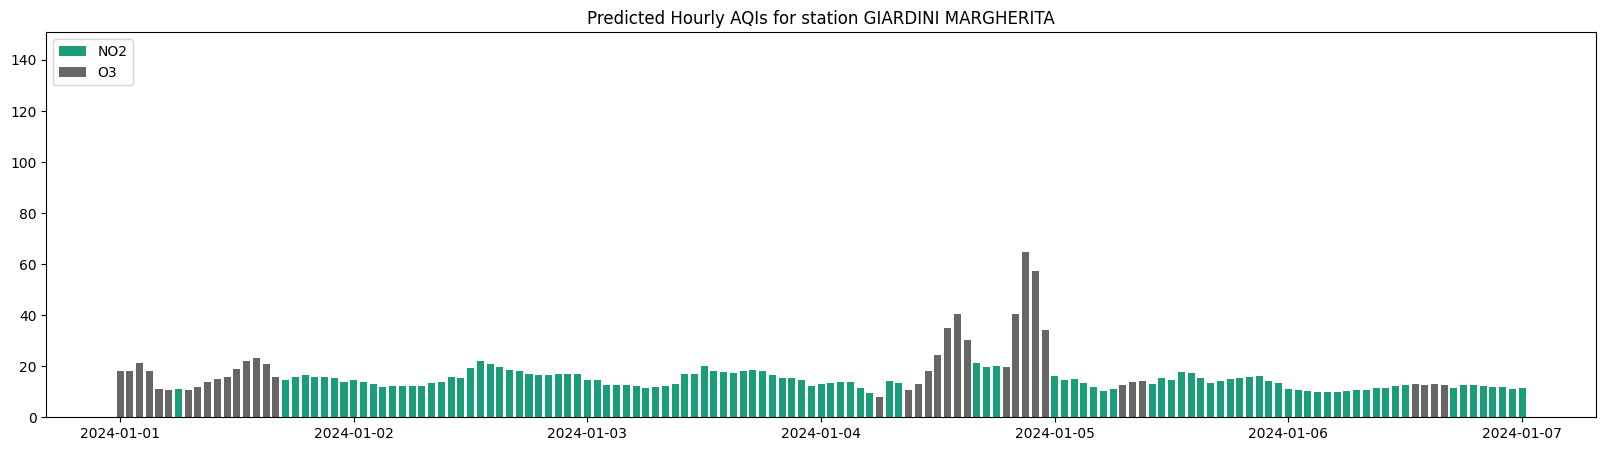

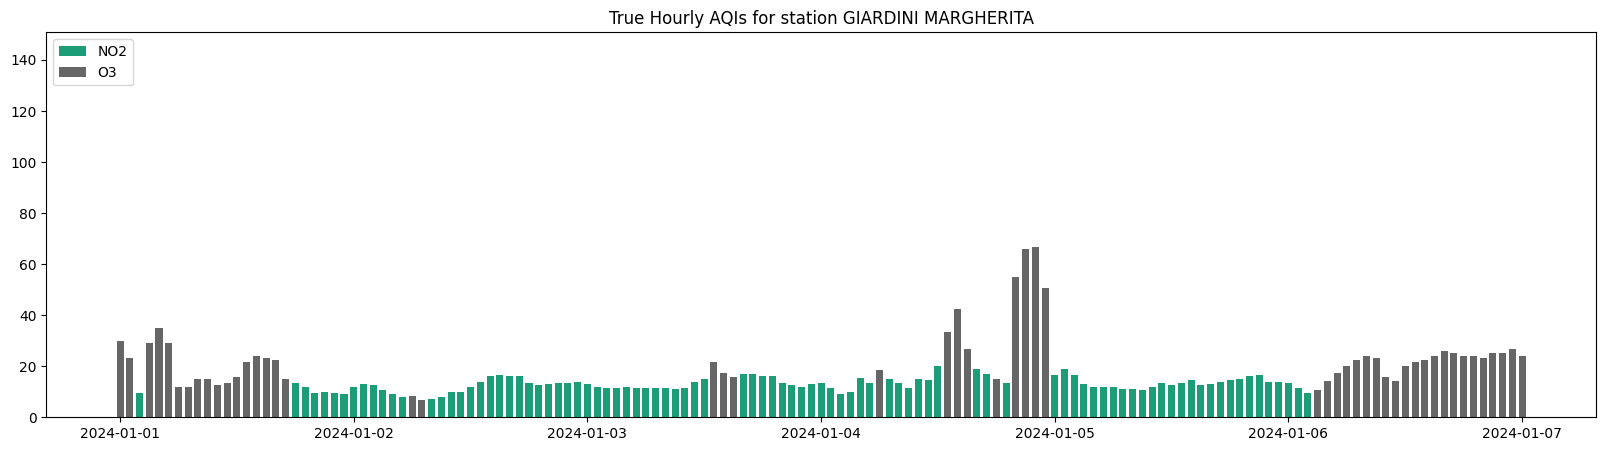

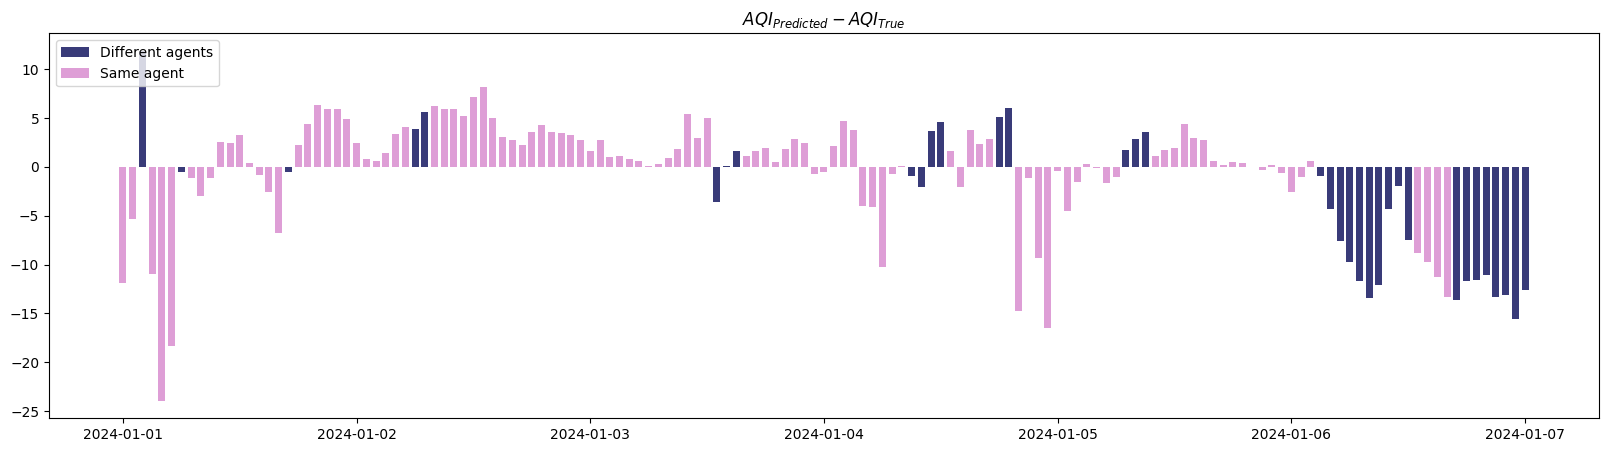

Station PORTA SAN FELICE AQI:


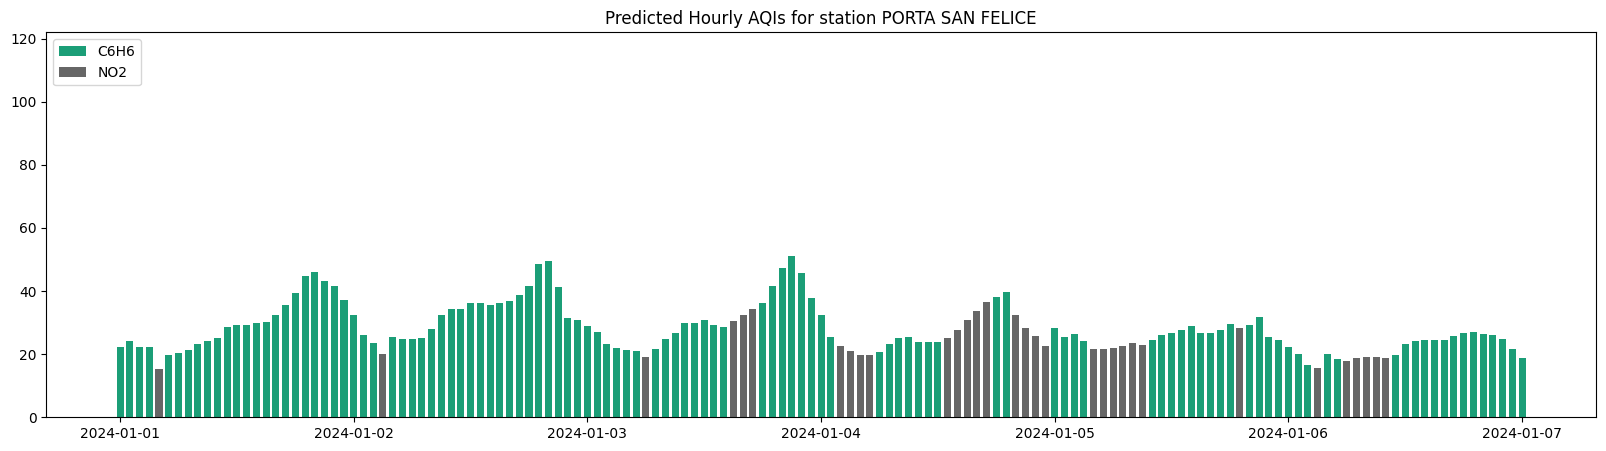

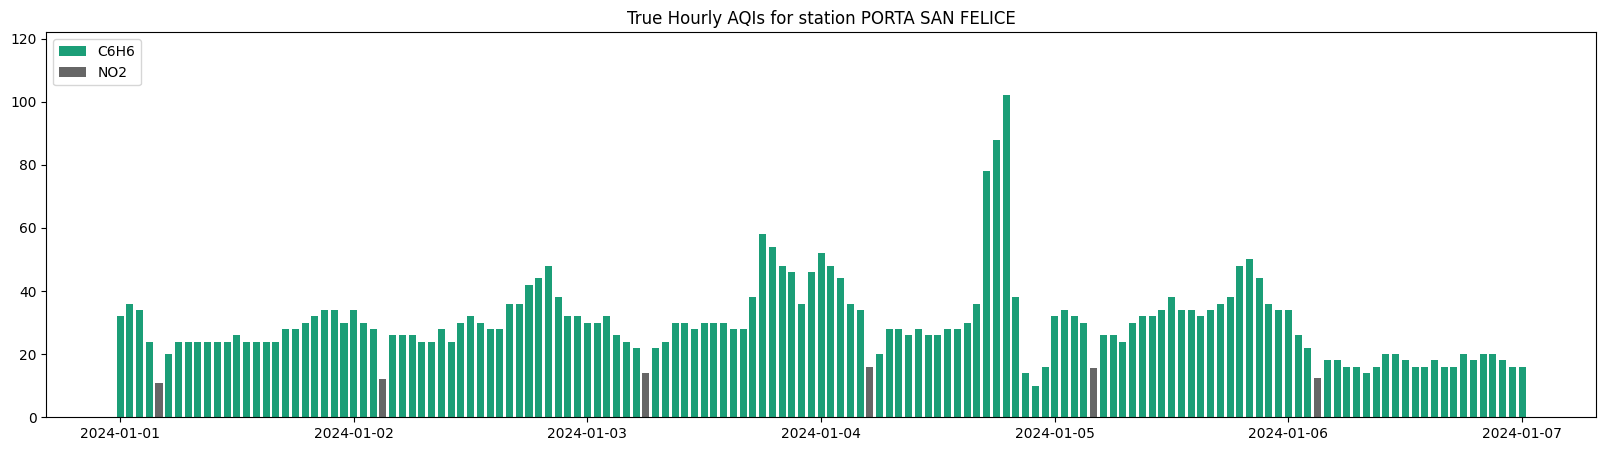

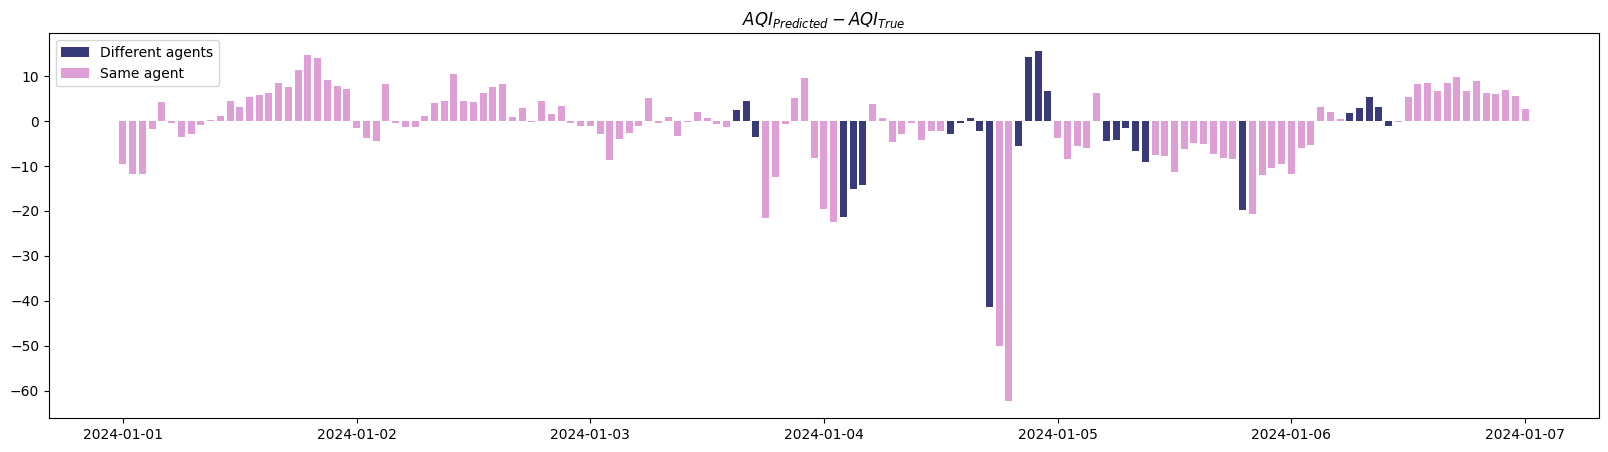

Station VIA CHIARINI AQI:


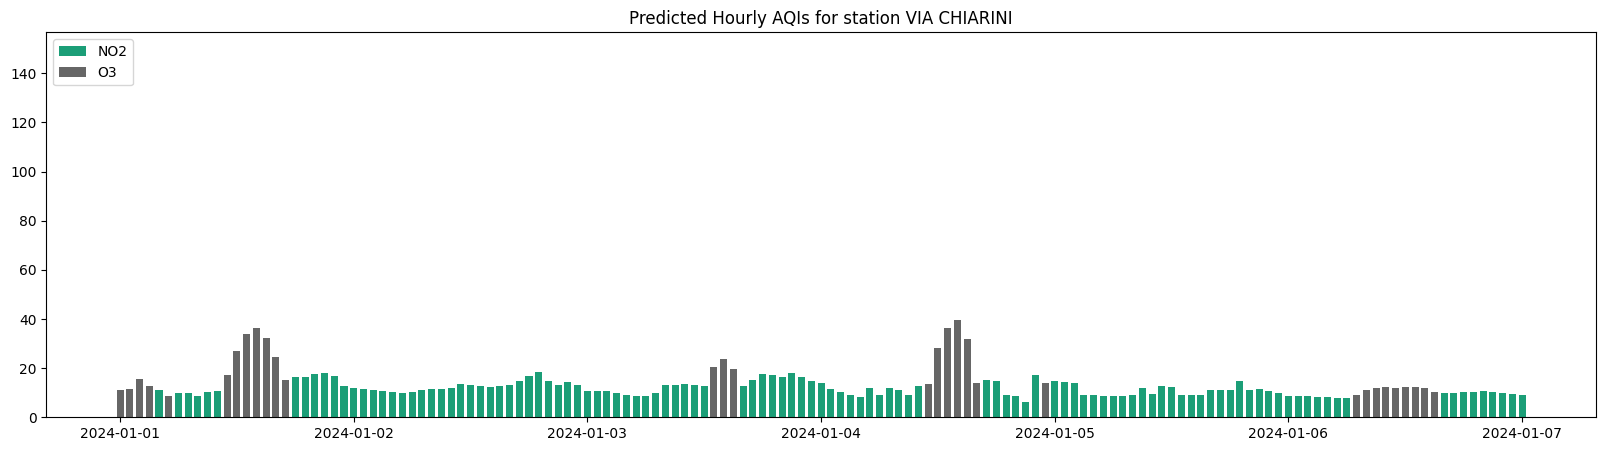

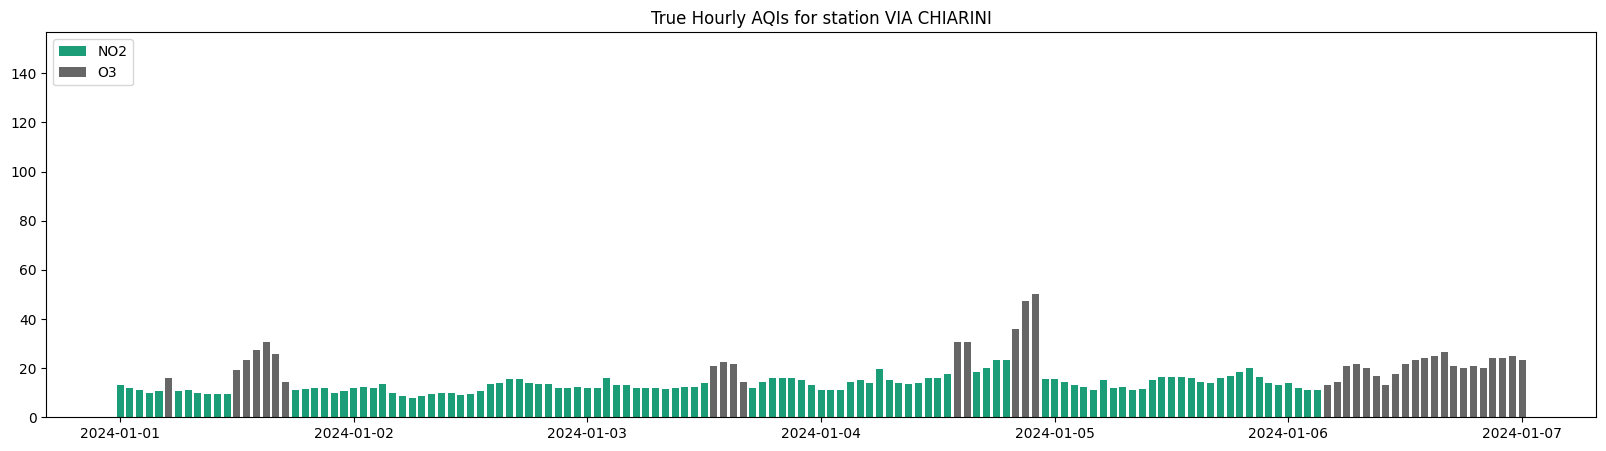

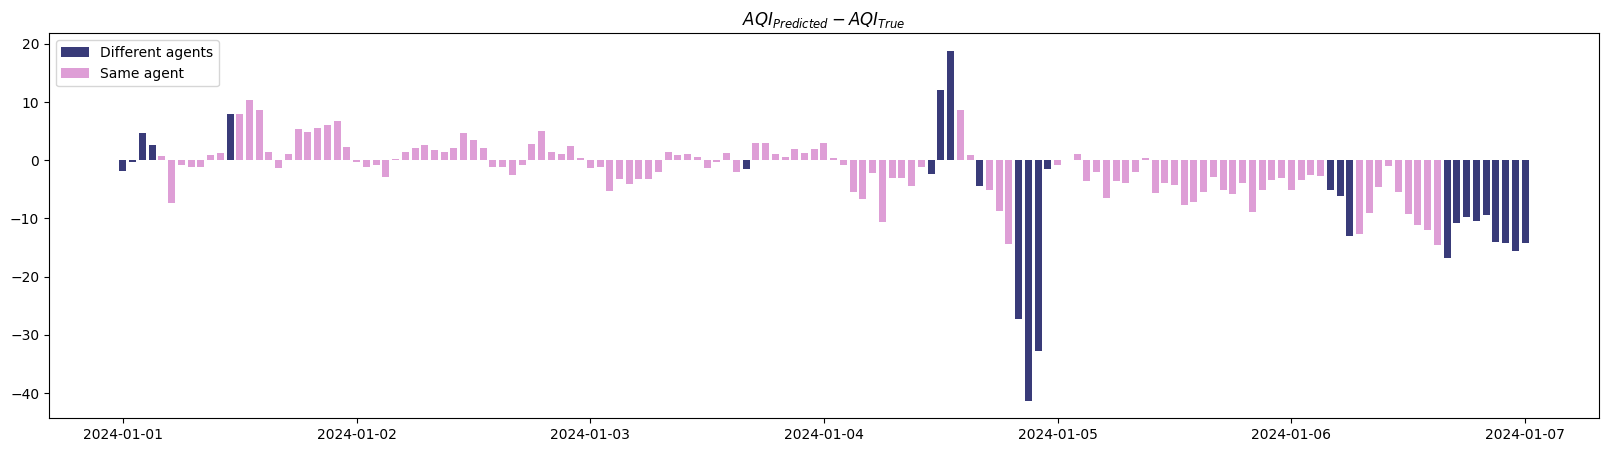

In [19]:
start=datetime(2024,1,1)
end=datetime(2024,1,7)

for station in true_AQIs_hourly:
    print(f'Station {station} AQI:')
    pred_ymax, true_ymax = pred_AQI_hourly[station]['AQI'].max(),true_AQI_hourly[station]['AQI'].max()
    ylims = [0, max(pred_ymax, true_ymax)]

    plot_AQI(
        station_AQI=[
            pred_AQI_hourly[station],
            true_AQI_hourly[station],
            AQI_diff_hourly[station]
        ], 
        title=[
            f'Predicted Hourly AQIs for station {station}',
            f'True Hourly AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ],
        figsize=(20, 5), s=start, e=end, ylims=ylims)

con step di 33 e xgb veniva .78, .89., 80, con i modelli veri 76 90 80
modell veri step di 50 viene 87 97 89

Station GIARDINI MARGHERITA


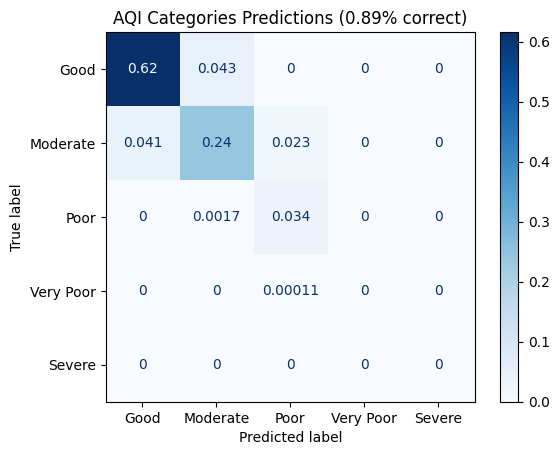

---------------------------------------------
> Absolute Mean AQI Difference: 7.88
> Positive Average AQI Difference: 7.85
> Negative Average AQI Difference: -7.91
> Percentage of Positive Differences: 55.29%
> Percentage of Negative Differences: 44.49%
> Percentage of Agent Values:
   - Same agent: 88.42
   - Different agents: 11.58


In [20]:
station = 'GIARDINI MARGHERITA'
print('=============================================')
print(f'Station {station}')
print('=============================================')
print_AQI_category_comparison(pred_AQI_hourly[station],true_AQI_hourly[station], categories=categories)
print('---------------------------------------------')
print_AQI_difference_metrics(AQI_diff_hourly[station])
print('=============================================')

Station PORTA SAN FELICE


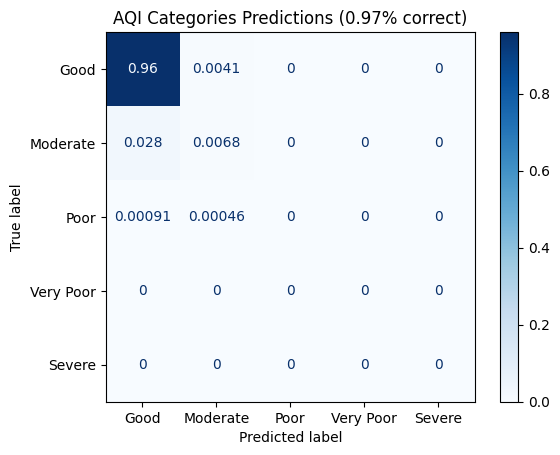

---------------------------------------------
> Absolute Mean AQI Difference: 6.09
> Positive Average AQI Difference: 5.51
> Negative Average AQI Difference: -6.90
> Percentage of Positive Differences: 58.16%
> Percentage of Negative Differences: 41.64%
> Percentage of Agent Values:
   - Same agent: 58.79
   - Different agents: 41.21


In [21]:
station = 'PORTA SAN FELICE'
print('=============================================')
print(f'Station {station}')
print('=============================================')
print_AQI_category_comparison(pred_AQI_hourly[station],true_AQI_hourly[station], categories=categories)
print('---------------------------------------------')
print_AQI_difference_metrics(AQI_diff_hourly[station])
print('=============================================')

Station VIA CHIARINI


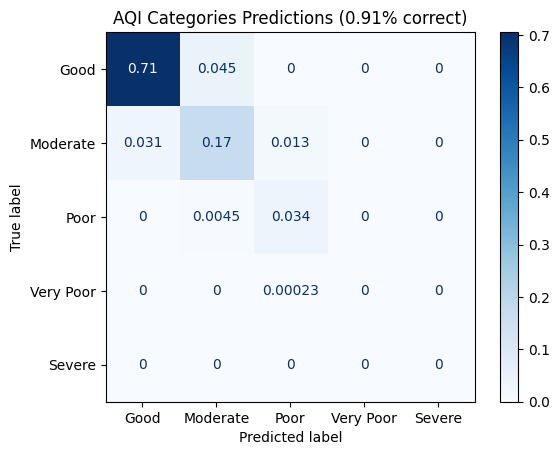

---------------------------------------------
> Absolute Mean AQI Difference: 7.60
> Positive Average AQI Difference: 8.27
> Negative Average AQI Difference: -6.85
> Percentage of Positive Differences: 52.30%
> Percentage of Negative Differences: 47.39%
> Percentage of Agent Values:
   - Same agent: 86.87
   - Different agents: 13.13


In [22]:
station = 'VIA CHIARINI'
print('=============================================')
print(f'Station {station}')
print('=============================================')
print_AQI_category_comparison(pred_AQI_hourly[station],true_AQI_hourly[station], categories=categories)
print('---------------------------------------------')
print_AQI_difference_metrics(AQI_diff_hourly[station])
print('=============================================')

### Daily AQI

Station GIARDINI MARGHERITA AQI:


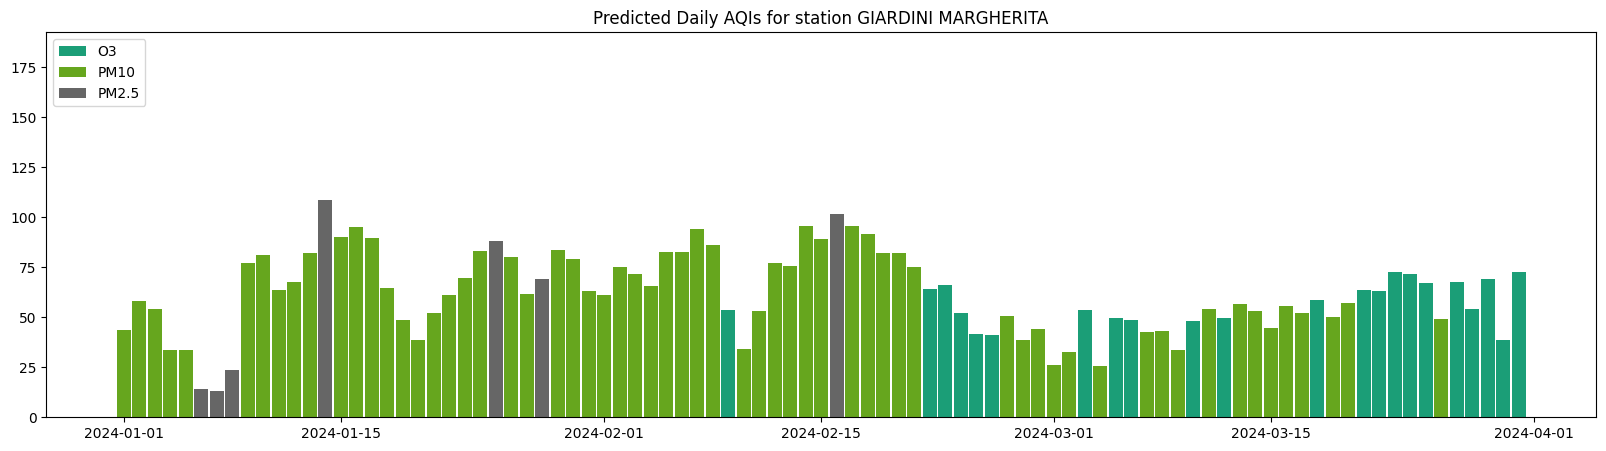

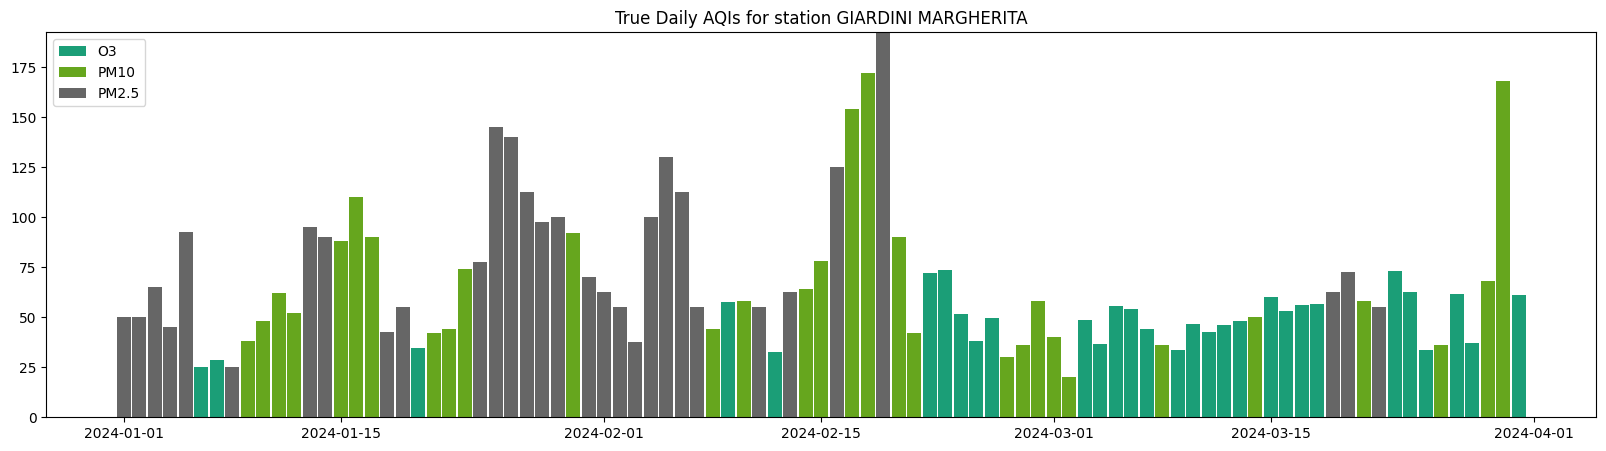

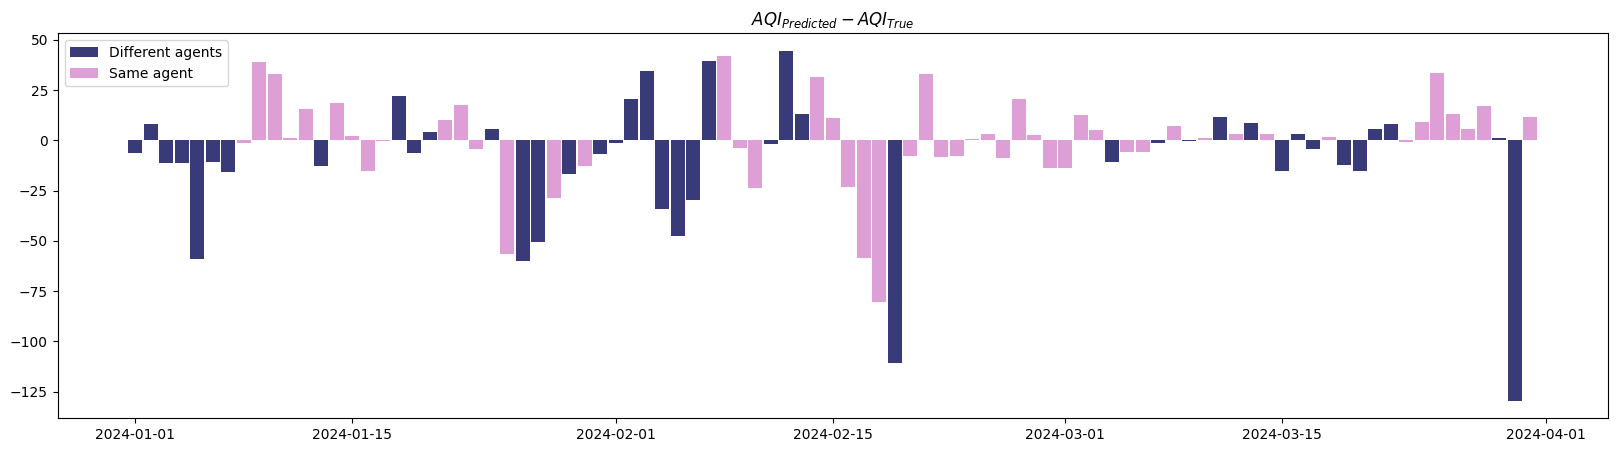

Station PORTA SAN FELICE AQI:


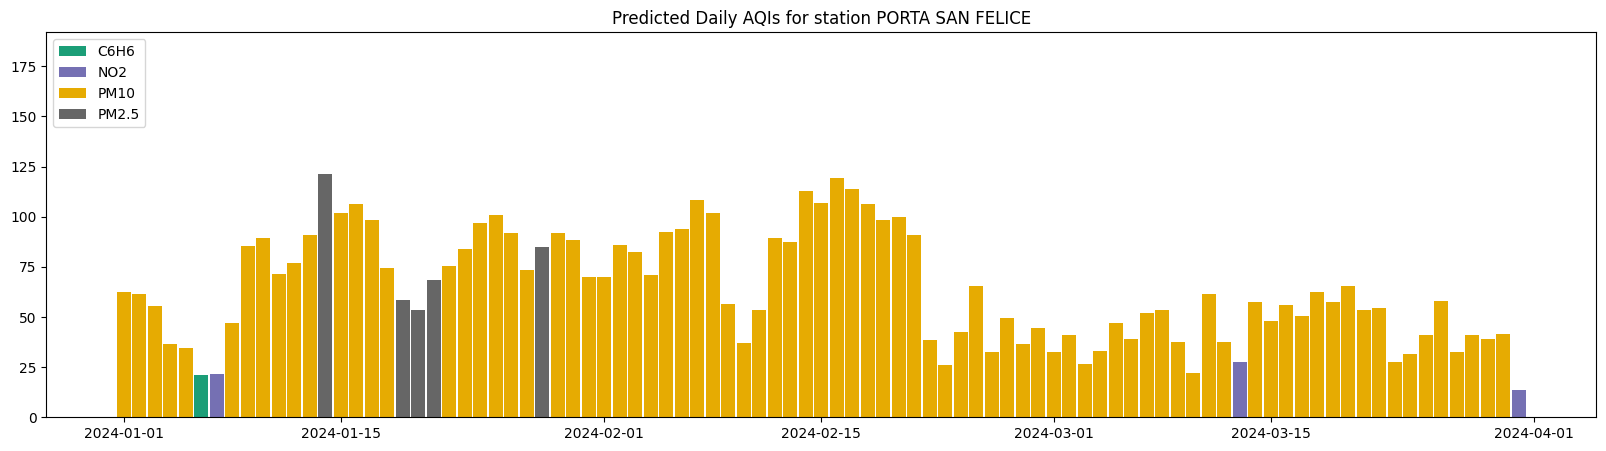

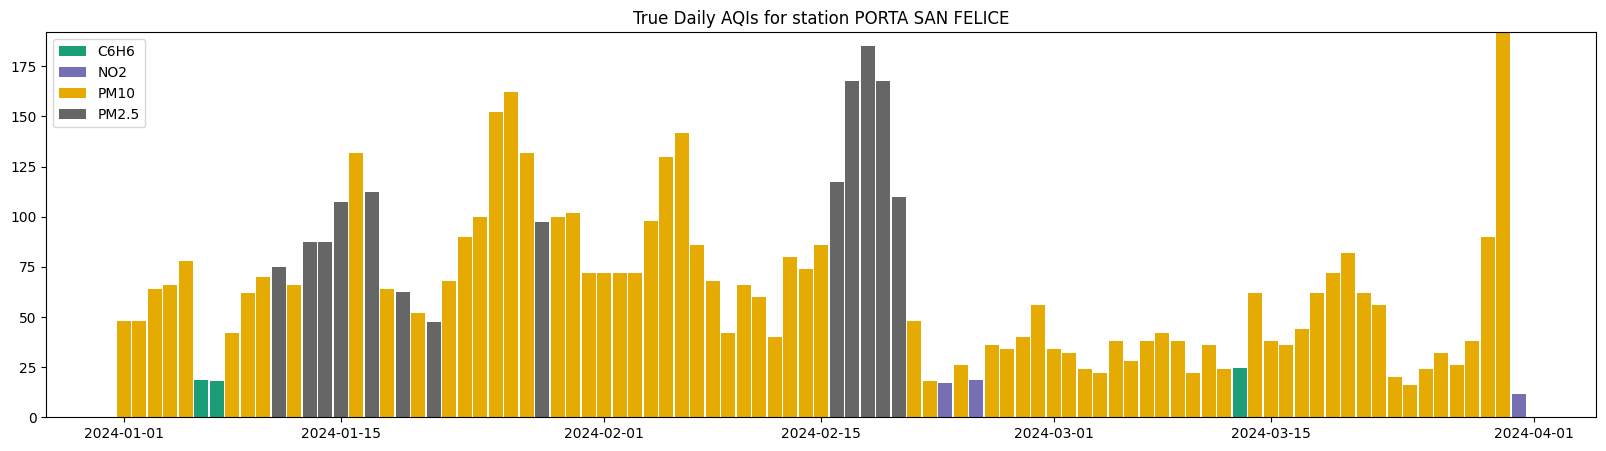

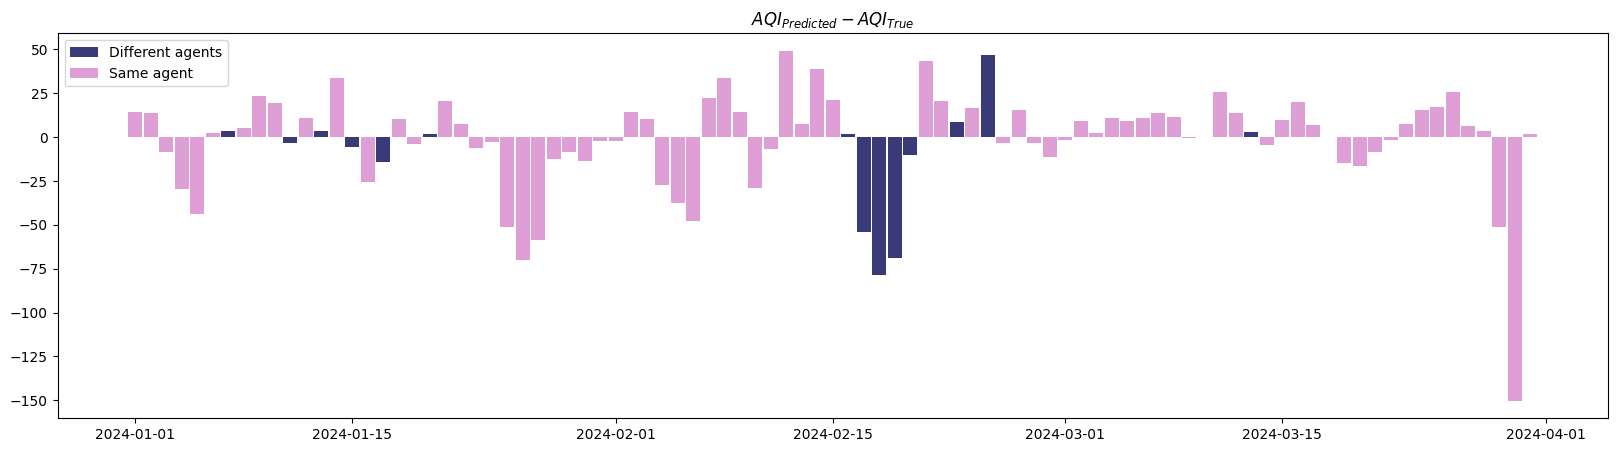

Station VIA CHIARINI AQI:


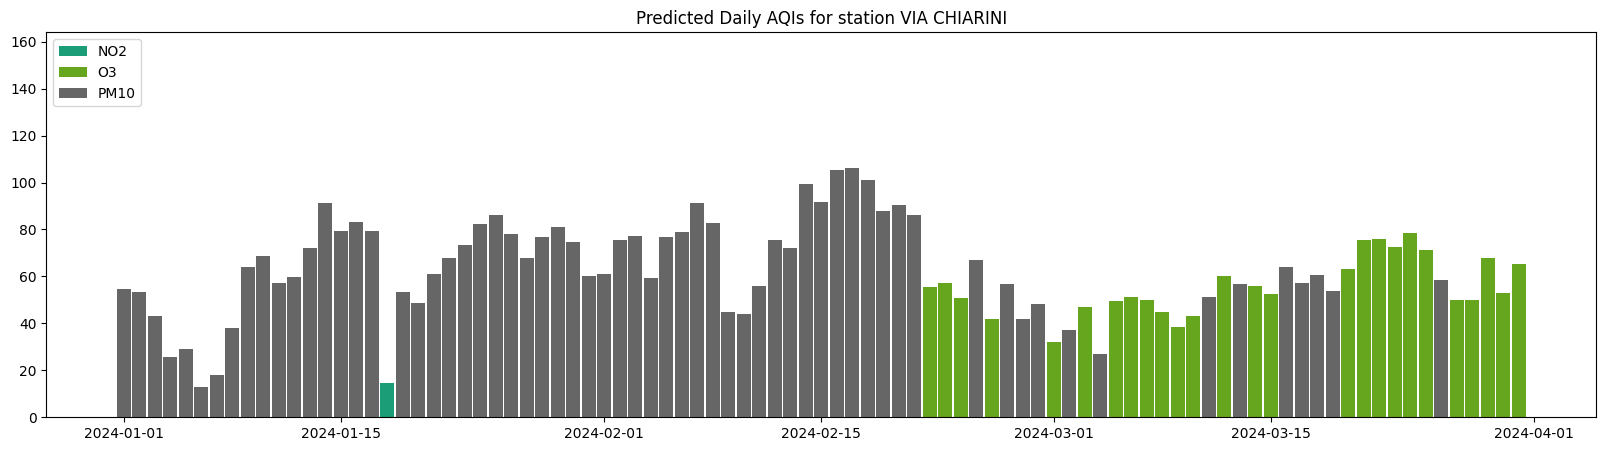

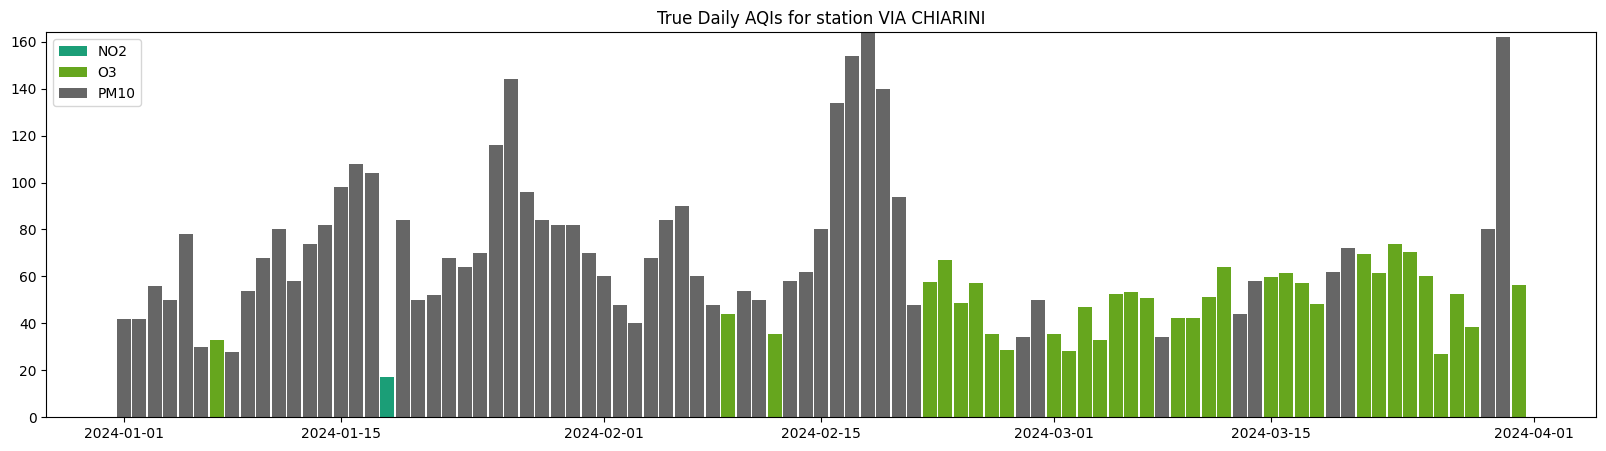

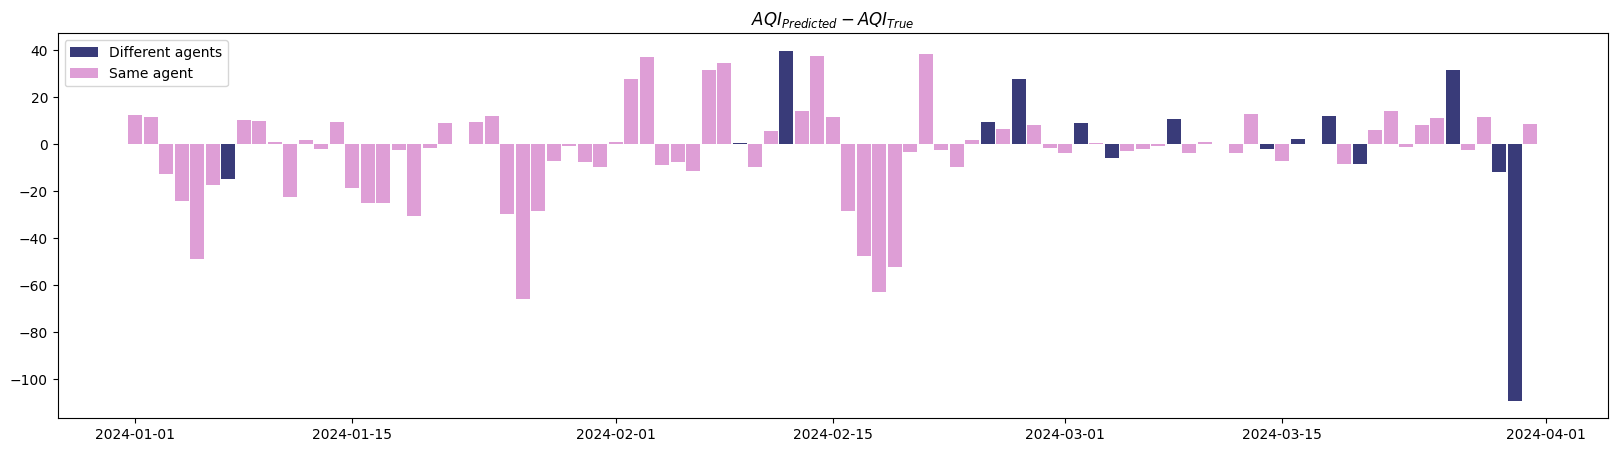

In [23]:
start=datetime(2024,1,1)
end=datetime(2024,3,31)

for station in true_AQIs_daily:
    print(f'Station {station} AQI:')
    pred_ymax, true_ymax = pred_AQI_daily[station]['AQI'].max(),true_AQI_daily[station]['AQI'].max()
    ylims = [0, max(pred_ymax, true_ymax)]

    plot_AQI(
        station_AQI=[
            pred_AQI_daily[station],
            true_AQI_daily[station],
            AQI_diff_daily[station]
        ], 
        title=[
            f'Predicted Daily AQIs for station {station}',
            f'True Daily AQIs for station {station}',
            r'$AQI_{Predicted} - AQI_{True}$'
        ], 
        figsize=(20, 5), s=start,e=end,ylims=ylims)

Station GIARDINI MARGHERITA


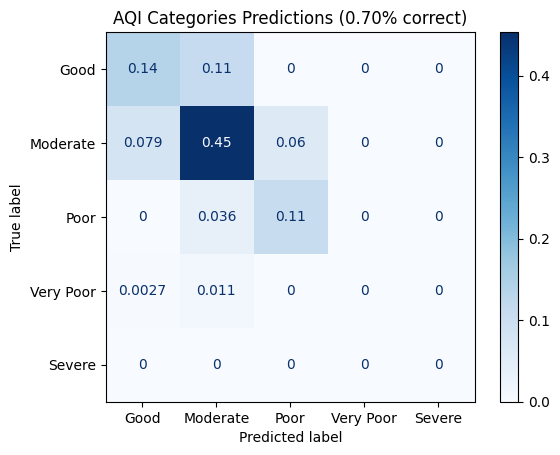

---------------------------------------------
> Absolute Mean AQI Difference: 14.25
> Positive Average AQI Difference: 12.18
> Negative Average AQI Difference: -16.91
> Percentage of Positive Differences: 56.28%
> Percentage of Negative Differences: 43.72%
> Percentage of Agent Values:
   - Same agent: 75.14
   - Different agents: 24.86


In [24]:
station = 'GIARDINI MARGHERITA'
print('=============================================')
print(f'Station {station}')
print('=============================================')
print_AQI_category_comparison(pred_AQI_daily[station],true_AQI_daily[station], categories=categories)
print('---------------------------------------------')
print_AQI_difference_metrics(AQI_diff_daily[station])
print('=============================================')

Station PORTA SAN FELICE


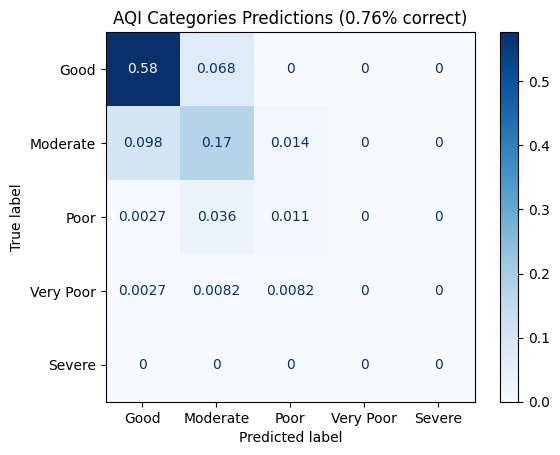

---------------------------------------------
> Absolute Mean AQI Difference: 14.28
> Positive Average AQI Difference: 10.65
> Negative Average AQI Difference: -18.59
> Percentage of Positive Differences: 54.37%
> Percentage of Negative Differences: 45.63%
> Percentage of Agent Values:
   - Same agent: 88.52
   - Different agents: 11.48


In [25]:
station = 'PORTA SAN FELICE'
print('=============================================')
print(f'Station {station}')
print('=============================================')
print_AQI_category_comparison(pred_AQI_daily[station],true_AQI_daily[station], categories=categories)
print('---------------------------------------------')
print_AQI_difference_metrics(AQI_diff_daily[station])
print('=============================================')

Station VIA CHIARINI


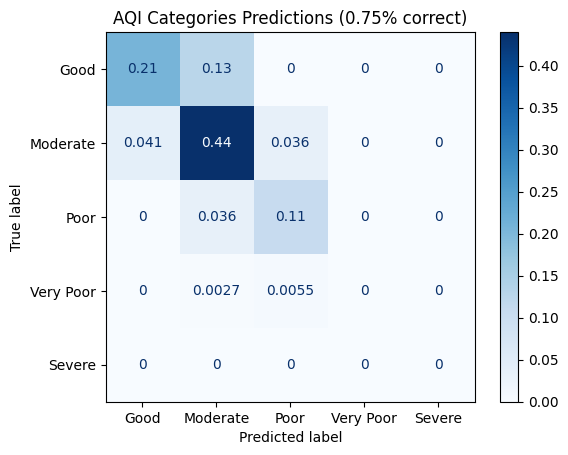

---------------------------------------------
> Absolute Mean AQI Difference: 11.84
> Positive Average AQI Difference: 11.02
> Negative Average AQI Difference: -13.20
> Percentage of Positive Differences: 62.30%
> Percentage of Negative Differences: 37.70%
> Percentage of Agent Values:
   - Same agent: 86.89
   - Different agents: 13.11


In [26]:
station = 'VIA CHIARINI'
print('=============================================')
print(f'Station {station}')
print('=============================================')
print_AQI_category_comparison(pred_AQI_daily[station],true_AQI_daily[station], categories=categories)
print('---------------------------------------------')
print_AQI_difference_metrics(AQI_diff_daily[station])
print('=============================================')